In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

from counterfactualgp import simulation
from counterfactualgp.bsplines import BSplines

In [2]:
rng = np.random.RandomState(0)

n_samples, n_train = 500, 300
avg_obs = 15
# Obs Time
low, high = 0.0, 24.0
prediction_times = [12.0]
time = prediction_times[0]
# Population
class_prob = [0.35, 0.35, 0.3]
n_classes = len(class_prob)
class_coef = np.array([
    [ 1.0,  0.9,  0.0, -0.5, -1.0],  # rapidly decline
    [ 1.0,  1.0,  0.5,  0.2,  0.2],  # mild decline
    [-0.3, -0.2, -0.2, -0.3, -0.2]   # stable
])
# Trajectory
n_bases, degree = class_coef.shape[1], 2
basis = BSplines(low, high, n_bases, degree, boundaries='space')
## Noise 
ln_a, ln_l, noise_scale = 2.0 * np.log(0.2), np.log(8.0), 0.1
# Treatment
rx_win, rx_effect = 2.0, 1.0
policy1_params =  2.0, 1.0, -0.5,    0.0  # History window, discount, policy weight, policy bias
policy2_params =  2.0, 1.0,  0.5,    0.0
policy3_params =  2.0, 1.0,  1.0,    0.0
policy4_params =  2.0, 1.0, -0.5,    0.0
policy1 = simulation.TreatmentPolicy(*policy1_params, rx_win, rx_effect)
policy2 = simulation.TreatmentPolicy(*policy2_params, rx_win, rx_effect)
policy3 = simulation.TreatmentPolicy(*policy3_params, rx_win, rx_effect)
policy4 = simulation.TreatmentPolicy(*policy4_params, rx_win, 0.0)  # Policy 1 with no effect.
## n_classes * n_policies
treatment_probs = [
    (0.2, 0.0, 0.0, 0.8),
    (0.9, 0.0, 0.0, 0.1),
    (0.5, 0.0, 0.0, 0.5)
]

In [3]:
obs_proc = simulation.ObservationTimes(low, high, avg_obs)

In [4]:
z = rng.choice(n_classes, size=n_samples, p=class_prob)

In [5]:
trajectories = [simulation.Trajectory(class_coef[_z], basis) for _z in z]
samples = [simulation.sample_trajectory(traj, obs_proc, ln_a, ln_l, noise_scale, rng) for traj in trajectories]

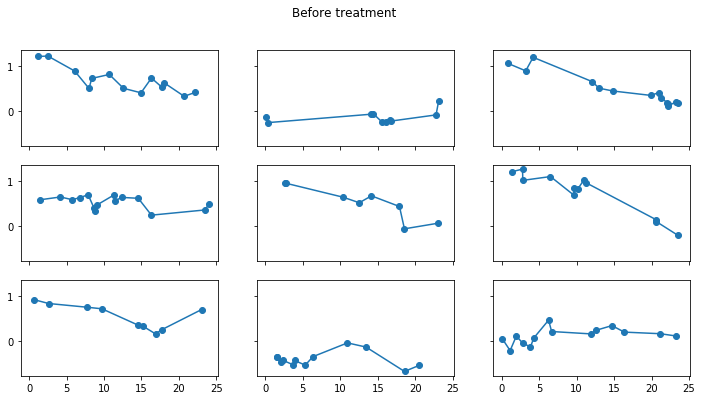

In [6]:
fig, axes = plt.subplots(3, 3, sharex=True, figsize=(12,6), sharey=True)
for i in range(3):
    for j in range(3):
        idx = i*3+j
        axes[i, j].plot(samples[idx][1], samples[idx][0], marker = 'o')
        
fig.suptitle('Before treatment')
plt.show()

In [7]:
train1 = simulation.treat_data_set(samples[:n_train], policy1, rng)
train2 = simulation.treat_data_set(samples[:n_train], policy2, rng)
test1 = simulation.truncate_treat_data_set(samples[n_train:], time, policy1, rng)
test2 = simulation.truncate_treat_data_set(samples[n_train:], time, policy2, rng)

policies = [policy1, policy2, policy3, policy4]
train3 = []
for _z, (y, t) in zip(z[:n_train], samples[:n_train]):
    policy = rng.choice(policies, p=treatment_probs[_z])
    train3.append(simulation.treat_sample(y, t, policy, rng))
test3 = []
for _z, (y, t) in zip(z[n_train:], samples[n_train:]):
    policy = rng.choice(policies, p=treatment_probs[_z])
    test3.append(simulation.treat_sample(y, t, policy, rng))

In [8]:
def draw_samples(samples, nrow=3, ncol=3, title='', truncated_time=None):
    fig, axes = plt.subplots(nrow, ncol, sharex=True, figsize=(12,6), sharey=True)
    for i in range(nrow):
        for j in range(ncol):
            idx = i*nrow+j
            axes[i, j].plot(samples[idx][1][0], samples[idx][0], marker = 'o', color = 'b')
            for t, rx in zip(samples[idx][1][0], samples[idx][1][1]):
                if rx == 1:
                    axes[i, j].axvline(x=t, color = 'y')
            if truncated_time is not None:
                axes[i, j].axvline(x=truncated_time, color='r', ls='--')
    fig.suptitle(title)
    plt.show()

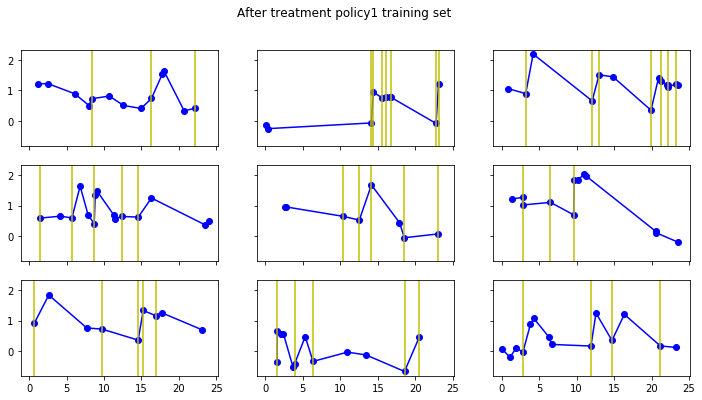

In [9]:
draw_samples(train1, 3, 3, 'After treatment policy1 training set')

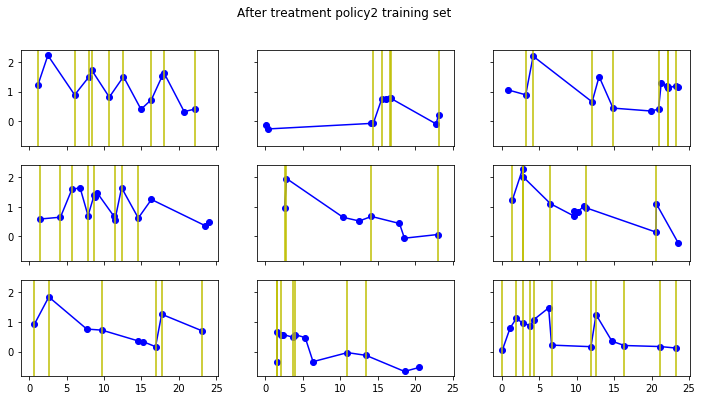

In [10]:
draw_samples(train2, 3, 3, 'After treatment policy2 training set')

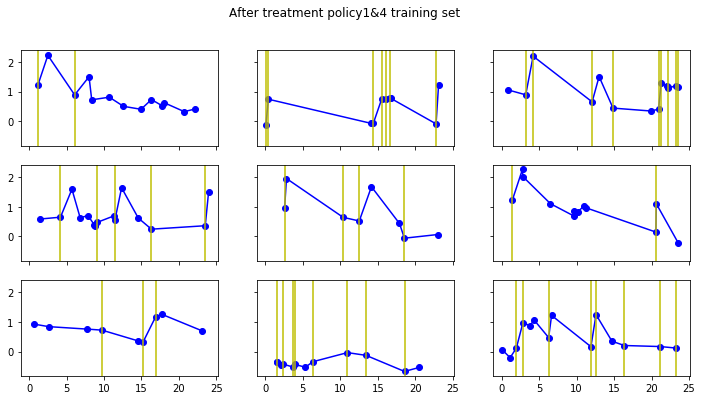

In [11]:
draw_samples(train3, 3, 3, 'After treatment policy1&4 training set')

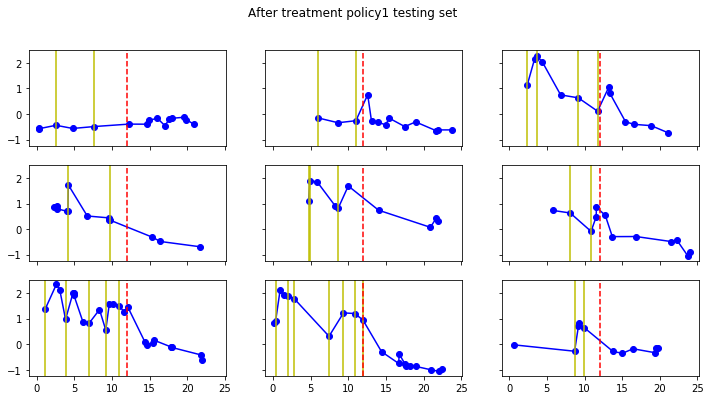

In [12]:
draw_samples(test1, 3, 3, 'After treatment policy1 testing set', truncated_time=time)

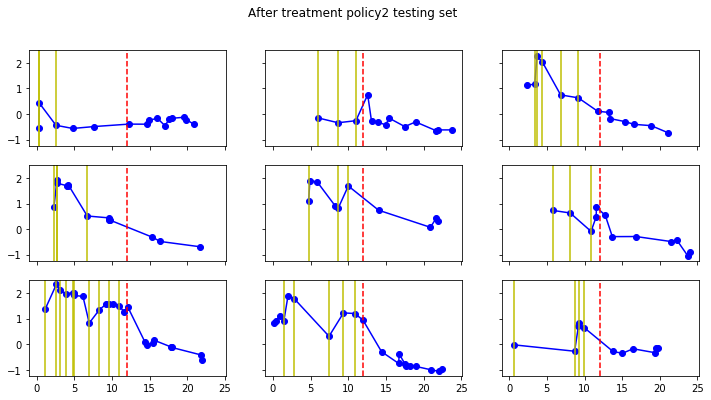

In [13]:
draw_samples(test2, 3, 3, 'After treatment policy2 testing set', truncated_time=time)

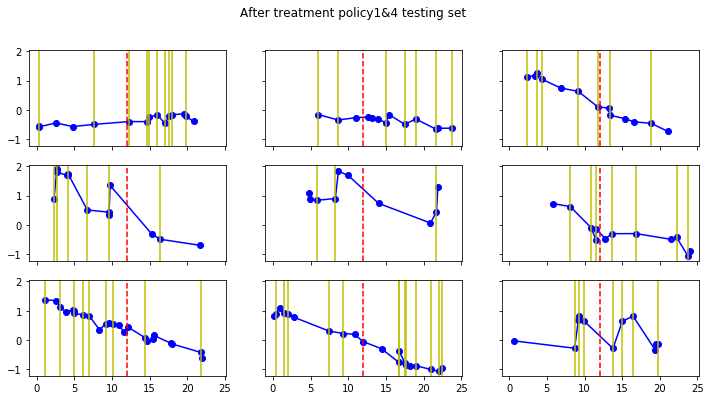

In [14]:
draw_samples(test3, 3, 3, 'After treatment policy1&4 testing set', truncated_time=time)

In [15]:
data_set = {
    'n_samples'     : n_samples,
    'n_train'       : n_train,
    'xlim'          : (low, high),
    'truncated_time': time,
    'class_prob'    : class_prob,
    'class_coef'    : class_coef,
    'classes'       : z,
    'samples'       : samples,
    'training1'     : train1,
    'testing1'      : test1,
    'training2'     : train2,
    'testing2'      : test2,
    'training3'     : train3,
    'testing3'      : test3,
}

output_dir = 'dataset'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(os.path.join(output_dir, 'data_set_bspline_3classes.pkl'), 'wb') as f:
    pickle.dump(data_set, f)